In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from fbprophet import Prophet
import seaborn as sns
from scipy import stats
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
world_df = pd.read_csv('covid-19.csv',parse_dates=['Date'])

In [3]:
world_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [4]:
world_df.describe()

,Id,ConfirmedCases,Fatalities
count,27231.000000,27231.000000,27231.000000
mean,17828.000000,1372.808050,75.991444
std,10300.673333,9488.242361,808.719059
min,1.000000,0.000000,0.000000
25%,8914.500000,0.000000,0.000000
50%,17828.000000,2.000000,0.000000
75%,26741.500000,138.000000,1.000000
max,35655.000000,230597.000000,22745.000000


In [5]:
world_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27231 entries, 0 to 27230
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Id              27231 non-null  int64         
 1   Province_State  11571 non-null  object        
 2   Country_Region  27231 non-null  object        
 3   Date            27231 non-null  datetime64[ns]
 4   ConfirmedCases  27231 non-null  float64       
 5   Fatalities      27231 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [6]:
world_df.isnull().values.any()

True

In [7]:
world_df.isnull().sum()

Id                    0
Province_State    15660
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64

In [ ]:
world_df.fillna({'Province_State': ""},inplace=True)

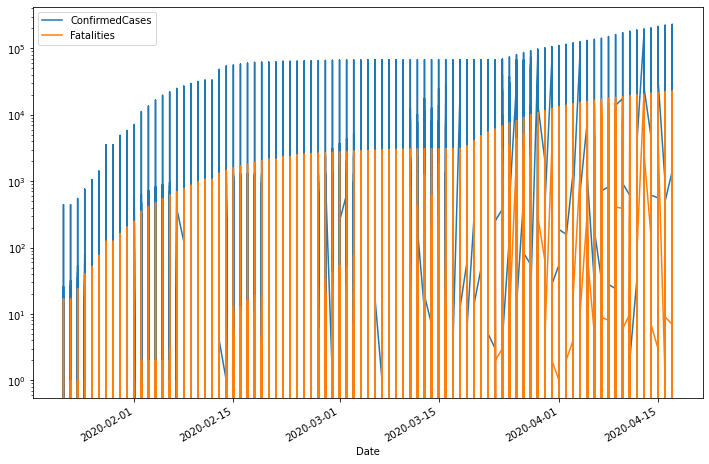

In [9]:
axis = world_df[['Date','ConfirmedCases','Fatalities']].set_index('Date').plot(figsize=(12, 8),logy=True)
plt.show()

In [ ]:
def mostEffectedCountries(world_df):
  """
  input - world_df dataframe
  output - country_df dataframe
  Takes world cases and provides most effected countries data
  """
  country_df = world_df.groupby('Country_Region')['ConfirmedCases'].sum().reset_index()
  country_df.sort_values(["ConfirmedCases"],ascending=False,inplace=True)
  return country_df


In [ ]:
country_df = mostEffectedCountries(world_df)

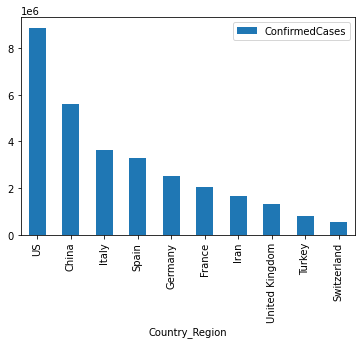

In [12]:
top_count = 10
country_df[:top_count].plot.bar(x='Country_Region',y = 'ConfirmedCases')

In [ ]:
def ConfirmedCasesStateWise(df,country):
  """
    Input - country - str takes county name
    df - dataframe - input data
    output - state_df - df returns most corona confirmed cases statewise data
  """
  country_df = df[df.Country_Region == country][['Province_State','ConfirmedCases']]
  state_df = country_df.groupby('Province_State')['ConfirmedCases'].sum().reset_index()
  state_df.sort_values('ConfirmedCases',ascending=False,inplace=True)
  return state_df 

In [ ]:
def FatalitiesStateWise(df,country):
  """
  Input - country - str takes county name
  df - dataframe - input data
  output - state_df - df returns most corona death cases statewise data
  """
  country_df = df[df.Country_Region == country][['Province_State','Fatalities']]
  state_df = country_df.groupby('Province_State')['Fatalities'].sum().reset_index()
  state_df.sort_values('Fatalities',ascending=False,inplace=True)
  return state_df

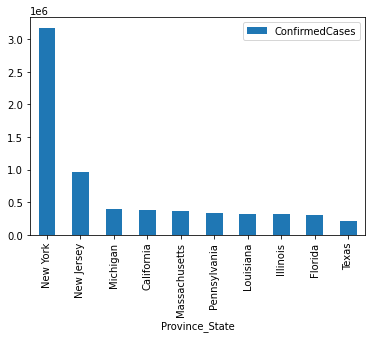

In [15]:
country = 'US'
state_df = ConfirmedCasesStateWise(world_df,country)
state_df[:10].plot.bar(x='Province_State',y = 'ConfirmedCases');

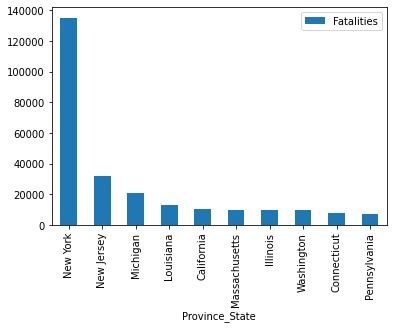

In [16]:
country = 'US'
state_death_df = FatalitiesStateWise(world_df,country)
state_death_df[:10].plot.bar(x='Province_State',y = 'Fatalities');

In [ ]:
def countryWisePredictions(df,country):
  country_df = world_df.groupby(['Country_Region','Date'])[['ConfirmedCases','Fatalities']].sum().reset_index()
  country_df = country_df[country_df.Country_Region == country]
  country_rn_df = country_df.rename(columns={"Date":"ds","ConfirmedCases":"y"})
  country_rn_df = country_rn_df.reset_index().drop(["index","Fatalities","Country_Region"],axis= 1)
  return country_rn_df


In [ ]:
def stateWisePredictions(df,country,state):
  state_df = df[(df["Country_Region"]==country) & (df["Province_State"]==state)][["Date","ConfirmedCases"]]
  state_rn_df = state_df.rename(columns={"Date":"ds","ConfirmedCases":"y"})
  state_rn_df = state_rn_df.reset_index().drop("index",axis= 1)
  return state_rn_df

In [ ]:
def train_test_data_split(df,period=5):
  train_data = df[:-period]
  test_data =  df[-period:]
  return train_data,test_data

In [ ]:
def modeling(train_data):
  pm = Prophet(changepoint_prior_scale=0.95,interval_width=1)
  pm.fit(train_data)
  return pm

In [ ]:
def predictions(pm,periods=5):
  future = pm.make_future_dataframe(periods)
  pm_forecast = pm.predict(future)
  return pm_forecast

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds          yhat    yhat_lower     yhat_upper        y
0 2020-04-13  83282.687872  80762.141702   86087.463151  83213.0
1 2020-04-14  83562.087199  77218.335449   88996.453444  83306.0
2 2020-04-15  82837.278993  70445.608661   91288.148294  83356.0
3 2020-04-16  83504.304086  64577.241540   97884.209729  83403.0
4 2020-04-17  83500.171389  60395.917091  104425.803917  83760.0





INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


China MAPE: 0.08367630072815894


          ds         yhat   yhat_lower   yhat_upper       y
0 2020-04-13  2816.136670  2691.672119  2930.686989  2579.0
1 2020-04-14  2905.181426  2776.156530  3062.525927  2613.0
2 2020-04-15  2999.264625  2811.588297  3182.953041  2643.0
3 2020-04-16  3085.852258  2874.251458  3295.035063  2672.0
4 2020-04-17  3173.303606  2943.569856  3500.632503  2700.0





INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Thailand MAPE: 8.420637821964084


          ds          yhat    yhat_lower    yhat_upper        y
0 2020-04-13  25251.232894  24247.281995  26101.163999  25667.0
1 2020-04-14  26524.512833  25563.044248  27422.363476  27022.0
2 2020-04-15  27778.315774  26716.943974  28735.327741  28196.0
3 2020-04-16  29117.606407  27458.010476  30360.275787  30796.0
4 2020-04-17  30313.606638  28158.290571  32416.317402  32801.0



Canada MAPE: 1.6465220062708334




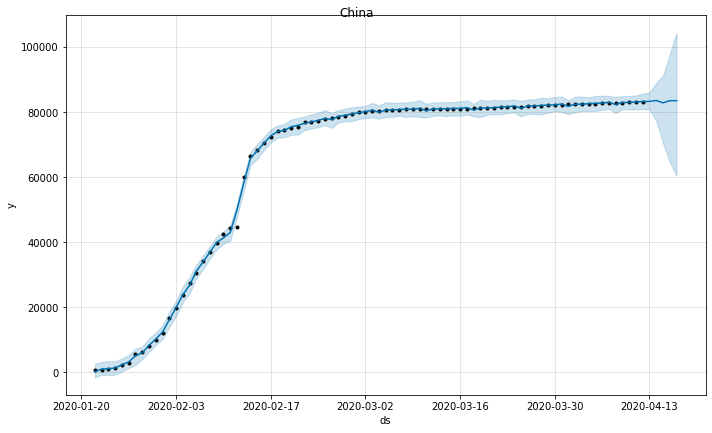

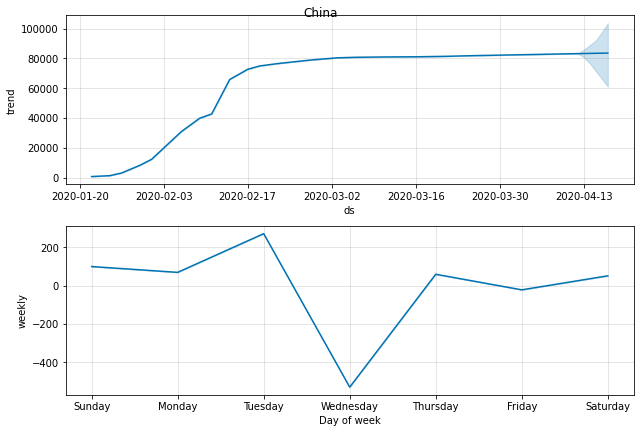

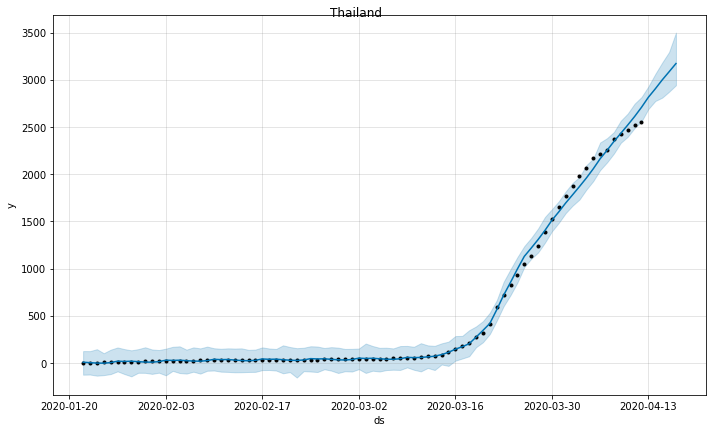

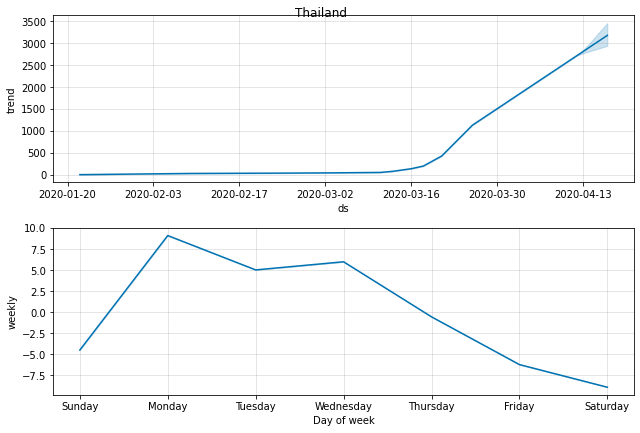

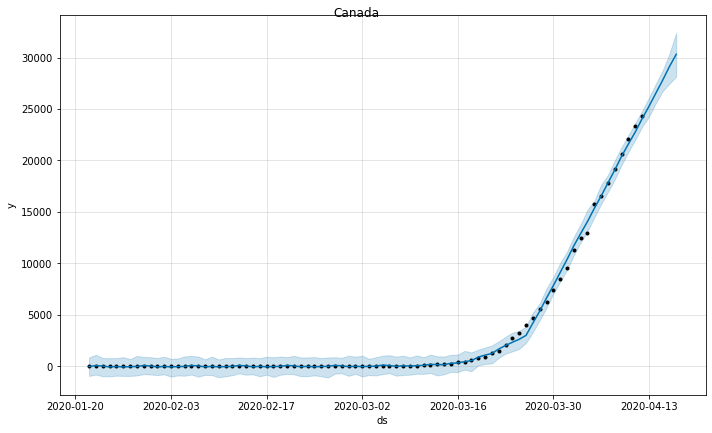

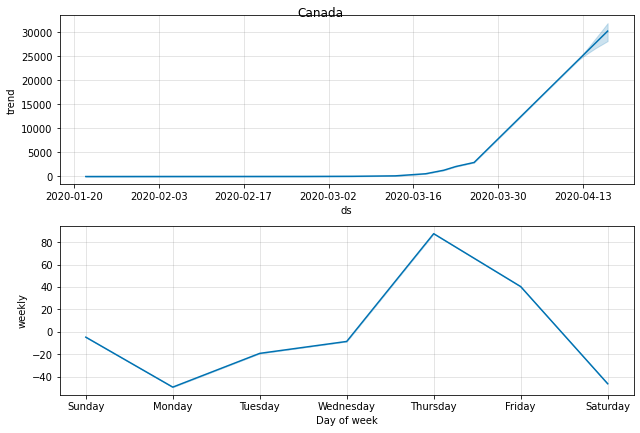

In [204]:

countries = ['China','Thailand','Canada']
for country in countries:
  # country = 'Canada'
  df = countryWisePredictions(world_df,country)
  train_data,test_data = train_test_data_split(df,5)
  pm = modeling(train_data)
  predictions_df = predictions(pm,5)
  results_df = predictions_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(test_data)
  print(results_df.tail(10))
  fig1 = pm.plot(predictions_df)
  fig1.suptitle(country,verticalalignment='center')
  fig2 = pm.plot_components(predictions_df)
  fig2.suptitle(country,verticalalignment='center')
  print(country+' MAPE: '+str(mean_absolute_percentage_error(results_df['yhat'].iloc[0], results_df['y'].iloc[0])))
  print('\n')